In [17]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import numpy as np

from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [14]:
def ecos_get(url: str):
    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        return r.json()
    except Exception as e:
        return {"error": str(e)}

def load_key_statistics():
    url = f"{ECOS_BASE}/KeyStatisticList/{ECOS_API_KEY}/json/kr/1/200/"
    js = ecos_get(url)
    rows = (js or {}).get("KeyStatisticList", {}).get("row", [])
    return rows if isinstance(rows, list) else []

def pick_by_names(rows, names):
    up_rows = [
        {**r, "_UP_NAME": (r.get("KEYSTAT_NAME") or "").strip().upper()} 
        for r in rows
    ]
    for name in names:
        key_up = name.strip().upper()
        for r in up_rows:
            if key_up in r["_UP_NAME"]:
                return r
    return None

def to_simple_record(r):
    if not r:
        return {"name": None, "value": None, "cycle": None, "unit": None, "class": None}
    return {
        "name": r.get("KEYSTAT_NAME"),
        "value": float(str(r.get("DATA_VALUE")).replace(",","")) if r.get("DATA_VALUE") else None,
        "cycle": r.get("CYCLE"),   # "2025.08" 이런 식으로 옴
        "unit": r.get("UNIT_NAME"),
        "class": r.get("CLASS_NAME"),
    }

TARGETS = {
    "policy_rate": ["한국은행 기준금리"],
    "gdp_qoq": ["경제성장률(실질, 계절조정 전기대비)"],
    "cpi": ["소비자물가지수(전년동월비)", "소비자물가지수"],
    "unemployment": ["실업률"],
}

rows = load_key_statistics()
ecos_out = {}
for key, names in TARGETS.items():
    ecos_out[key] = to_simple_record(pick_by_names(rows, names))

df_ecos = pd.DataFrame.from_dict(ecos_out, orient="index").reset_index()
df_ecos.rename(columns={"index":"indicator"}, inplace=True)

df_ecos

      indicator                  name   value     cycle      unit       class
0   policy_rate             한국은행 기준금리    2.50  20251001         %        시장금리
1       gdp_qoq  경제성장률(실질, 계절조정 전기대비)    0.70    2025Q2         %         성장률
2           cpi               소비자물가지수  116.45    202508  2020=100  소비자/생산자 물가
3  unemployment                   실업률    2.00    202508         %          고용


In [18]:
df_fake = pd.DataFrame({
    "date": pd.date_range(start="2025-09-01", periods=30, freq="D"),
    "news_count": np.random.randint(50, 200, size=30),      # 기사 수 랜덤
    "sentiment_avg": np.random.uniform(-1, 1, size=30),     # 감정 점수 랜덤
    "keyword_diversity": np.random.uniform(3, 10, size=30)  # 평균 키워드 수
})

df_fake["month"] = df_fake["date"].dt.to_period("M")
print(df_fake.head())

        date  news_count  sentiment_avg  keyword_diversity    month
0 2025-09-01          86      -0.638723           6.337772  2025-09
1 2025-09-02         186       0.579550           7.018624  2025-09
2 2025-09-03          55       0.835142           4.374444  2025-09
3 2025-09-04          57      -0.891022           6.454157  2025-09
4 2025-09-05         155       0.134536           3.667029  2025-09


In [20]:
# =================================
# 1. 내부지표 (뉴스 → 월 단위 집계)
# =================================
# df_news: MongoDB에서 가져온 뉴스 데이터프레임이라고 가정
df_news["published_at"] = pd.to_datetime(df_news["published_at"])
df_news["month"] = df_news["published_at"].dt.to_period("M").astype(str)

# 내부 지표 정의
df_news["keyword_count"] = df_news["keywords"].apply(lambda x: len(x) if isinstance(x, list) else 0)

df_internal = df_news.groupby("month").agg(
    news_count=("category", "count"),             # 기사 수
    sentiment_avg=("sentiment_score", "mean"),    # 평균 감정 점수
    keyword_diversity=("keyword_count", "mean")   # 기사당 평균 키워드 수
).reset_index()

In [21]:
# =================================
# 2. 외부지표 (ECOS → DataFrame)
# =================================
# df_ecos: 이미 ecos.py 코드로 불러온 데이터라고 가정
# 예: indicator, value, cycle, unit 등 포함

# cycle을 str로 변환해서 month와 맞추기
df_ecos["cycle"] = df_ecos["cycle"].astype(str)

# indicator별 컬럼으로 pivot
df_ecos_pivot = df_ecos.pivot(index="cycle", columns="indicator", values="value")

In [22]:
# =================================
# 3. 내부 vs 외부 merge
# =================================
df_merge = df_internal.merge(
    df_ecos_pivot,
    left_on="month", right_index=True, how="inner"
)

print("결합된 데이터:")
print(df_merge.head())

결합된 데이터:
Empty DataFrame
Columns: [month, news_count, sentiment_avg, keyword_diversity, cpi, gdp_qoq, policy_rate, unemployment]
Index: []


C:\Users\OWNER\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\OWNER\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


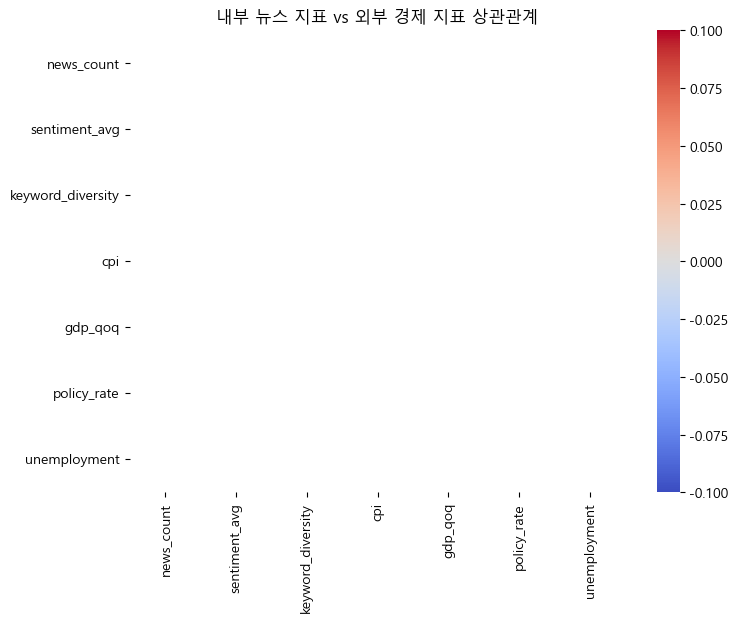

In [23]:
# =================================
# 4. 상관관계 히트맵
# =================================
corr = df_merge.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("내부 뉴스 지표 vs 외부 경제 지표 상관관계")
plt.show()

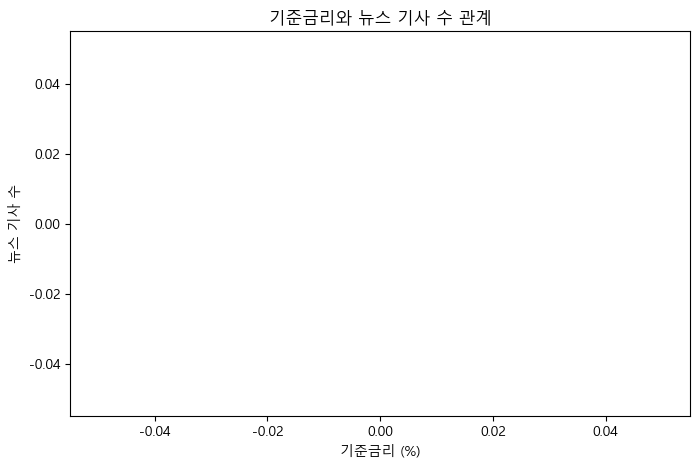

In [24]:
# =================================
# 5. 산점도 예시 (기준금리 vs 뉴스 수)
# =================================
if "policy_rate" in df_merge.columns:
    plt.figure(figsize=(8,5))
    plt.scatter(df_merge["policy_rate"], df_merge["news_count"], alpha=0.7)
    plt.xlabel("기준금리 (%)")
    plt.ylabel("뉴스 기사 수")
    plt.title("기준금리와 뉴스 기사 수 관계")
    plt.show()
else:
    print("⚠️ df_merge에 'policy_rate' 컬럼이 없습니다.")